In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
mnist_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

mnist_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

### Generating artificially partial labelled dataset

In [4]:
def generate_partial_labelled(dataset, r, p) :

    # List to store the inputs in numpy array format
    x = []

    # List to store the outputs in numpy array format
    y = []

    for i in range(len(dataset)) :

        original_label = dataset[i][1]

        labels = []
        labels.append(original_label)

        if np.random.rand() <= p :
            for j in range(r) :
                # Find a label other than the original one and append it
                new_label = np.random.randint(0, 10)
                while new_label in labels :
                    new_label = np.random.randint(0, 10)
                
                labels.append(new_label)
        
        x.append(dataset[i][0].detach().numpy().reshape(28, 28))

        # One hot encoding the labels before appending to the y list
        one_hot = np.zeros(10, dtype='float32')

        for label in labels :
            one_hot[label] = 1

        # Regularization
        one_hot = one_hot/sum(one_hot)

        y.append(one_hot)

    return np.array(x), np.array(y)

In [5]:
# Creating custom dataset and dataloader
class mnist_partial_dataset(Dataset) :
    def __init__(self, dataset, r, p) :
        self.x, self.y = generate_partial_labelled(dataset, r, p)
        self.length = len(self.x)


    def __getitem__(self, index) :
        return self.x[index], self.y[index]

    def __len__(self) :
        return self.length

In [6]:
train_dataset = mnist_partial_dataset(mnist_train, 1, 0.2)
train_dataloader = DataLoader(train_dataset, 32, shuffle=True)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(110, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, 784)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 11)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc4(x), 0.2)
        return x

In [8]:
D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.MSELoss()

# optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
G_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [20]:
def train_D(x, y) :
    D.zero_grad()

    batch_size = len(x)

    # Training on real data
    x_real, y_real = x.view(-1, 784), torch.concat((y, torch.zeros(batch_size, 1)), 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # Training of fake data
    z = torch.concat((torch.randn(batch_size, 100), y), 1).to(device)

    x_fake = G(z)
    y_fake = torch.concat((torch.zeros(batch_size, 10), torch.ones(batch_size, 1)), 1)
    y_fake = y_fake.to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()


def train_G(x, y) :
    G.zero_grad()

    batch_size = len(x)

    z = torch.concat((torch.randn(batch_size, 100), y), 1).to(device)
    y_real = torch.concat((y, torch.zeros(batch_size, 1)), 1).to(device)

    G_output = G(z)

    D_output = D(G_output)
    G_loss = criterion(D_output, y_real)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [21]:
n_epoch = 10
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, y) in enumerate(train_dataloader):
        G_losses.append(train_G(x, y))
        D_losses.append(train_D(x, y))

    print(f'{epoch}/{n_epoch}: loss_d: {torch.mean(torch.FloatTensor(D_losses))}, loss_g: {torch.mean(torch.FloatTensor(G_losses))}')

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

tensor([[-0.0310, -0.0195, -0.0140,  0.0648, -0.0123, -0.0203, -0.0070, -0.0209,
         -0.0028, -0.0045,  0.9299]], device='cuda:0')
tensor(1.4855)


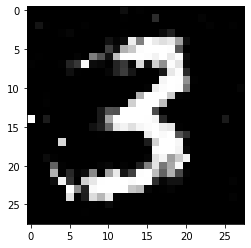

In [ ]:
image_grid = []

with torch.no_grad() :
    for num in range(10) :
        for i in range(10) :
            y = torch.zeros(1,10)
            y[0][num] = 1
            z = torch.concat((torch.randn(1, 100), y), 1).to(device)

            output = G(z)

            output = output.cpu().detach().numpy()
            output = output.reshape(28, 28)

            image_grid.append(output)

In [ ]:
torch.save(D.state_dict(), './models/mnist_r_value_1_p_value_0.7.pt')